In [1]:
import os
import fitsio
import numpy as np
from astropy.table import Table

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='white', font_scale=1.6)

colors = sns.color_palette('Set1', n_colors=14, desat=0.75)

# color-blind friendly color cycle:
# https://twitter.com/rachel_kurchin/status/1229567059694170115
cb_colors = {'blue': '#377eb8',
             'orange': '#ff7f00',
             'green': '#4daf4a',
             'pink': '#f781bf',
             'brown': '#a65628',
             'purple': '#984ea3',
             'gray': '#999999',
             'red': '#e41a1c',
             'yellow': '#dede00'}

%matplotlib inline

In [3]:
bands = ['FUV', 'NUV', 'g', 'r', 'z', 'W1', 'W2', 'W3', 'W4']
pixscales = {'FUV': 1.5, 'NUV': 1.5, 'g': 0.262, 'r': 0.262, 
             'z': 0.262, 'W1': 2.75, 'W2': 2.75, 'W3': 2.75, 'W4': 2.75}
resamp_pixscale = 0.75
SBTHRESH = [22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26] # surface brightness thresholds
APERTURES = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0] # multiples of MAJORAXIS

In [4]:
# see also Morrisey+05
effwave_north = {
    'fuv': 1528.0, 'nuv': 2271.0,
    'w1': 34002.54044482, 'w2': 46520.07577119, 'w3': 128103.3789599, 'w4': 223752.7751558,
    'g': 4815.95363513, 'r': 6437.79282937, 'z': 9229.65786449}
effwave_south = {
    'fuv': 1528.0, 'nuv': 2271.0,
    'w1': 34002.54044482, 'w2': 46520.07577119, 'w3': 128103.3789599, 'w4': 223752.7751558,
    'g': 4890.03670428, 'r': 6469.62203811, 'z': 9196.46396394}

In [5]:
version = '0.3.2'
projectdir = '/global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga'

### SED Modeling

In [6]:
fitsio.FITS('/global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga/fsps.fits')


  file: /global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga/fsps.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FLUX
  2      IMAGE_HDU       INTSFH
  3      IMAGE_HDU       MREMAIN
  4      IMAGE_HDU       METS
  5      IMAGE_HDU       M50
  6      IMAGE_HDU       M300
  7      IMAGE_HDU       M1000
  8      BINARY_TBL      MODELS

In [7]:
fitsio.FITS('/global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga/mnsa-0.3.2.fits')


  file: /global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga/mnsa-0.3.2.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      SUMMARY
  2      BINARY_TBL      ELLIPSE
  3      BINARY_TBL      CENTRAL_FLUX
  4      BINARY_TBL      PIPE3D
  5      BINARY_TBL      SPS_AP02
  6      BINARY_TBL      SPS_AP03
  7      BINARY_TBL      SPS_AP04
  8      BINARY_TBL      SPS_AP05
  9      BINARY_TBL      SPS_AP06
  10     BINARY_TBL      SPS_AP07
  11     BINARY_TBL      SPS_AP08

In [8]:
fitsio.FITS('/global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga/mnsa-0.3.2.fits')['SUMMARY']


  file: /global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga/mnsa-0.3.2.fits
  extension: 1
  type: BINARY_TBL
  extname: SUMMARY
  rows: 11273
  column info:
    plate               i8  
    ifudsgn            S32  
    plateifu           S32  
    mangaid            S32  
    versdrp2           S32  
    versdrp3           S32  
    verscore           S32  
    versutil           S32  
    versprim           S32  
    platetyp           S32  
    srvymode           S32  
    objra               f8  
    objdec              f8  
    ifuglon             f8  
    ifuglat             f8  
    ifura               f8  
    ifudec              f8  
    ebvgal              f8  
    nexp                i8  
    exptime             f8  
    drp3qual            i8  
    bluesn2             f8  
    redsn2              f8  
    harname            S53  
    frlplug             i8  
    cartid             S32  
    designid            i8  
    cenra               f8  
    cendec              f8

In [9]:
def read_mnsa(HDU=None, do_sps=True):
    mnsafile = os.path.join(projectdir, f'mnsa-{version}.fits')
    
    if HDU is None:
        print('HDU input is required')
        print(fitsio.FITS(mnsafile))
        return
    
    cat = Table(fitsio.read(mnsafile, HDU))
    print(f'Read {len(cat)} rows from {mnsafile}')
    if do_sps and 'do_sps' in cat.colnames:
        I = cat['do_sps']
        print(f'Trimming to {np.sum(I)}/{len(cat)} rows with do_sps=True.')
        cat = cat[I]
    
    return cat

In [10]:
C_LIGHT = 2.99e18
kspecfit = fitsio.FITS(kspecfile)
print(kspecfit)
kwave = kspecfit['WAVE'].read()
kspec = kspecfit['FLUX'].read()
kspec = kspec[done, :]
kspec = 10**(0.4*48.6) * kwave**2 / C_LIGHT * kspec # AB mag
kspec.shape
#khdr = kspecfit['WAVE'].read_header()

NameError: name 'kspecfile' is not defined

In [ ]:
list(effwave_south.values())

In [ ]:
def stats_deltamag():
    aps = ['ap02', 'ap03']#, 'ap04', 'ap05', 'ap06', 'ap07', 'ap08']
    naps = len(aps)
    nband = len(bands)
    
    out = Table()
    out['ap'] = aps
    out['mean'] = np.zeros((naps, nband), 'f4')
    out['sigma'] = np.zeros((naps, nband), 'f4')
    
    for iap, ap in enumerate(aps):
        cat = read_mnsa(HDU=f'sps_{ap}')
        
        for iband in range(nband):
            I = np.where((cat['maggies'][:, iband] > 0) * (cat['rmaggies'][:, iband] > 0))[0]
            mdata = -2.5 * np.log10(cat['maggies'][I, iband])
            mmodel = -2.5 * np.log10(cat['rmaggies'][I, iband])
            deltam = mdata - mmodel
            qq = np.percentile(deltam, [50, 25, 75])
            mn, sd = np.mean(deltam), np.std(deltam)
            
            out['mean'][iap, iband] = mn
            out['sigma'][iap, iband] = sd
            
    return out

out = stats_deltamag()

In [11]:
out

NameError: name 'out' is not defined

In [12]:
weff = np.array(list(effwave_south.values()))
weff = weff[np.argsort(weff)]
#plt.errorbar(weff, out[0]['mean'], out[0]['sigma'], fmt='s', capsize=3)
plt.fill_between(weff, out[1]['mean']-out[1]['sigma'], out[1]['mean']+out[1]['sigma'])
plt.ylim(-1, 1)
plt.xscale('log')
plt.axhline(y=0, color='k', ls='--')

NameError: name 'out' is not defined

In [15]:
def qa_deltamag(aperture='ap05', snrcut=3.):

    cat = read_mnsa(HDU=f'sps_{aperture}')
    
    magrange = np.array([-4, 4])

    uvlim = [12, 28]
    grzlim = [10, 23]
    irlim = [8, 23]
    xylim = {'FUV': uvlim, 'NUV': uvlim, 'g': grzlim, 'r': grzlim, 
             'z': grzlim, 'W1': irlim, 'W2': irlim, 'W3': irlim, 'W4': irlim}
    
    fig, ax = plt.subplots(3, 3, figsize=(12, 11), sharey=True)
    for iband, (band, xx) in enumerate(zip(bands, ax.flat)):
        I = np.where((cat['maggies'][:, iband] * np.sqrt(cat['ivar'][:, iband]) > snrcut) * (cat['rmaggies'][:, iband] > 0))[0]
        #I = np.where((cat['maggies'][:, iband] > 0) * (cat['rmaggies'][:, iband] > 0))[0]
        mdata = -2.5 * np.log10(cat['maggies'][I, iband])
        mmodel = -2.5 * np.log10(cat['rmaggies'][I, iband])
        deltam = mdata - mmodel
        qq = np.percentile(deltam, [50, 25, 75])
        #print(band, qq)
        mn, sd = np.mean(deltam), np.std(deltam)
        lo, hi = qq[1], qq[2]
        if lo < 0:
            lop = ''
        else:
            lop = '+'
        if hi < 0:
            hip = ''
        else:
            hip = '+'
        stats = '${:.3f}\pm{:.3f}$ $({:.3f}^{{{}{:.3f}}}_{{{}{:.3f}}})$'.format(
            mn, sd, qq[0], lop, lo, hip, hi)
        #print(stats)
        #xx.scatter(mmodel, deltam, s=3, marker='s', color=colors[iband],
        #           alpha=0.3, 
        #           label='{} (N={})'.format(band, len(I)))
        xx.hexbin(mmodel, deltam, mincnt=1, cmap='Blues_r',
                  extent=(*xylim[band], *magrange),
                  gridsize=100,
                  #label='{} (N={})'.format(band, len(I))
                  label='{}: {}'.format(band, stats)
                 )
        #print(band, quant)
        #xx.hist(deltam, bins=30, range=magrange, log=False, color=colors[iband],
        #        cumulative=True, density=True, histtype='stepfilled', lw=2,
        #        edgecolor='k',
        #        label='{} (N={})'.format(band, len(I)))
        xx.axhline(y=0, ls='--', color='k')
        xx.set_ylim(magrange)
        xx.set_xlim(xylim[band])
        #xx.legend(loc='upper left', frameon=False, fontsize=12)
        xx.text(0.05, 0.9, 
                '{} (N={})'.format(band, len(I)),
                fontsize=14,
                va='center', ha='left', transform=xx.transAxes)
        tt = xx.text(0.05, 0.1, 
                '{}'.format(stats),                
                fontsize=11, 
                va='center', ha='left', transform=xx.transAxes)
        tt.set_bbox(dict(facecolor='lightgray', alpha=0.8, edgecolor='k'))
        
    ax[1, 0].set_ylabel(r'$m_{data} - m_{model}$')
    ax[2, 1].set_xlabel(r'$m_{model}$')
    fig.subplots_adjust(wspace=0.08, hspace=0.18)

Read 11273 rows from /global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga/mnsa-0.3.2.fits
Trimming to 10207/11273 rows with do_sps=True.


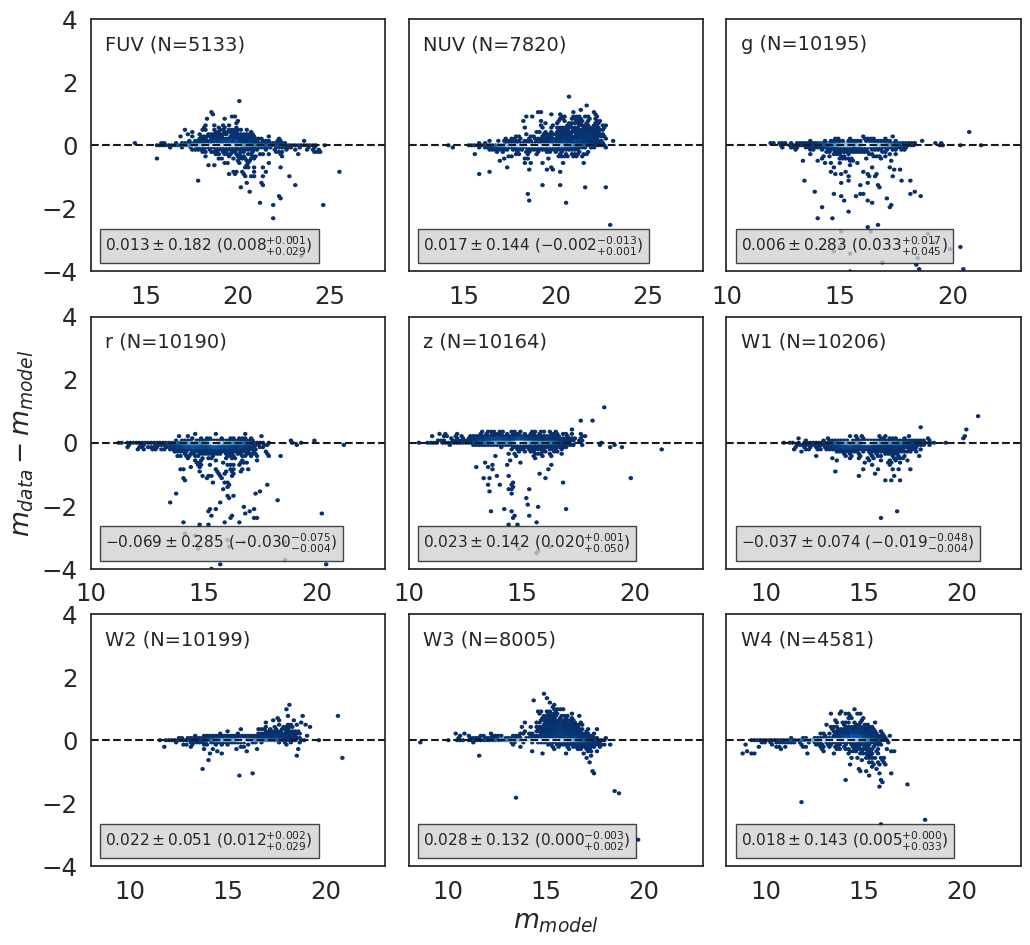

In [19]:
qa_deltamag(aperture='ap06', snrcut=3.)

In [20]:
def qa_multiwavelength_sed(kcorr, kspec, png=None, verbose=True):
    """Plot up the multiwavelength SED.

    """
    import matplotlib.pyplot as plt
    from copy import deepcopy
    import matplotlib.ticker as ticker
            
    if kcorr['hemi'] == 'north':
        effwave = effwave_north
    else:
        effwave = effwave_south

    # build the arrays
    nband = len(bands)
    bandwave = np.array([effwave[filt.lower()] for filt in bands])

    _phot = {'abmag': np.zeros(nband, 'f4')-1,
             'abmagerr': np.zeros(nband, 'f4')+0.5,
             'upper': np.zeros(nband, bool)}
    phot = {'mag': deepcopy(_phot), 'modelmag': deepcopy(_phot)}

    for ifilt, filt in enumerate(bands):
        flux = kcorr['maggies'][ifilt]
        ivar = kcorr['ivar'][ifilt]
        modelflux = kcorr['rmaggies'][ifilt]
        #print(flux, ivar, modelflux)
        if flux > 0 and ivar > 0:
            mag = -2.5 * np.log10(flux)
            ferr = 1.0 / np.sqrt(ivar)
            magerr = 2.5 * ferr / flux / np.log(10)
            phot['mag']['abmag'][ifilt] = mag
            phot['mag']['abmagerr'][ifilt] = magerr
            phot['mag']['upper'][ifilt] = False
        if flux <=0 and ivar > 0:
            ferr = 1.0 / np.sqrt(ivar)
            mag = -2.5 * np.log10(ferr)
            phot['mag']['abmag'][ifilt] = mag
            phot['mag']['abmagerr'][ifilt] = 0.75
            phot['mag']['upper'][ifilt] = True

        modelmag = -2.5 * np.log10(modelflux)
        phot['modelmag']['abmag'][ifilt] = modelmag
            
    def _addphot(thisphot, color, marker, alpha, label, model=False):
        if model:
            ax.scatter(bandwave/1e4, thisphot['abmag'], lw=3,
                       marker=marker, s=300, facecolor='none', color='k',
                       alpha=alpha, label=label)
            return
            
        good = np.where((thisphot['abmag'] > 0) * (thisphot['upper'] == True))[0]
        if len(good) > 0:
            ax.errorbar(bandwave[good]/1e4, thisphot['abmag'][good], yerr=thisphot['abmagerr'][good],
                        marker=marker, markersize=11, markeredgewidth=3, markeredgecolor='k',
                        markerfacecolor=color, elinewidth=3, ecolor=color, capsize=4,
                        lolims=True, linestyle='none', alpha=alpha)#, lolims=True)
                        
        good = np.where((thisphot['abmag'] > 0) * (thisphot['upper'] == False))[0]
        if len(good) > 0:
            ax.errorbar(bandwave[good]/1e4, thisphot['abmag'][good], yerr=thisphot['abmagerr'][good],
                        marker=marker, markersize=11, markeredgewidth=3, markeredgecolor='k',
                        markerfacecolor=color, elinewidth=3, ecolor=color, capsize=4,
                        label=label, linestyle='none', alpha=alpha)
    
    # make the plot
    fig, ax = plt.subplots(figsize=(9, 7))

    # get the plot limits
    good = np.where(phot['mag']['abmag'] > 0)[0]
    ymax = np.min(phot['mag']['abmag'][good])
    ymin = np.max(phot['mag']['abmag'][good])

    if np.min(phot['modelmag']['abmag']) < ymax:
        ymax = np.min(phot['tractor']['abmag'])
    if np.max(phot['modelmag']['abmag']) > ymin:
        ymin = np.max(phot['modelmag']['abmag'])
    #print(ymin, ymax)

    ymin += 1.5
    ymax -= 1.5

    wavemin, wavemax = 0.1, 30

    # have to set the limits before plotting since the axes are reversed
    if np.abs(ymax-ymin) > 15:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.set_ylim(ymin, ymax)
    
    _addphot(phot['mag'], color='red', marker='o', alpha=1.0, label=r'Measured Photometry (Ap04)')
    _addphot(phot['modelmag'], color='k', marker='s', alpha=1.0, label='Model Photometry', model=True)
    
    print(-2.5*np.log10(kspec / (1+kcorr['redshift'])))
    ax.plot(kwave * (1+kcorr['redshift']) / 1e4, -2.5*np.log10(kspec / (1+kcorr['redshift'])))

    ax.set_xlabel(r'Observed-frame Wavelength ($\mu$m)') 
    ax.set_ylabel(r'Apparent Brightness (AB mag)') 
    ax.set_xlim(wavemin, wavemax)
    ax.set_xscale('log')
    ax.legend(loc='lower right')

    def _frmt(value, _):
        if value < 1:
            return '{:.1f}'.format(value)
        else:
            return '{:.0f}'.format(value)

    ax.set_xticks([0.1, 0.2, 0.4, 1.0, 3.0, 5.0, 10, 20])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(_frmt))
    fig.subplots_adjust(left=0.14, bottom=0.15, top=0.95, right=0.95)

    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        plt.close(fig)
    else:
        plt.show()
        
#I = kcorr['plateifu'] == '10001-3701'
#I = kcorr['plateifu'] == '10214-3703'
I = kcorr['plateifu'] == '10511-1902'
qa_multiwavelength_sed(kcorr[I][0], kspec[I][0])

NameError: name 'kcorr' is not defined

In [21]:
assert(np.all(parent['PLATEIFU'] == kcorr['plateifu']))
plt.scatter(np.log10(ellipse['MAJORAXIS']), np.log10(kcorr['chi2']), s=1)
plt.scatter(np.log10(ellipse['MAJORAXIS'])[7], np.log10(kcorr['chi2'])[7], s=200, marker='x', color='k')
plt.ylim(-1, 4)

NameError: name 'parent' is not defined

In [33]:
I = np.where(parent['PLATEIFU'] == '10214-3703')[0]
#print(parent[I])
print(I)
for iband, band in enumerate(['FUV', 'NUV', 'g', 'r', 'z', 'W1', 'W2', 'W3', 'W4']):
    size = ellipse[I]['MAJORAXIS'][0]
    sma = ellipse[I]['SMA_AP04'][0]
    mm = ellipse[I]['FLUX_AP04_{}'.format(band.upper())][0]
    dust = ellipse[I]['MW_TRANSMISSION_{}'.format(band.upper())][0]
    pdust = 22.5-2.5*np.log10(mm)
    pp = 22.5-2.5*np.log10(mm/dust)
    kk = -2.5*np.log10(kcorr[kcorr['plateifu'] == '10001-3701']['maggies'][0, iband])
    print(band, size*0.262, sma, mm, kk)

[42]
FUV 25.642224563598635 25.642223 -0.06936741 nan
NUV 25.642224563598635 25.642223 0.2109728 24.604663848876953
g 25.642224563598635 25.642223 108.972046 18.088257312774658
r 25.642224563598635 25.642223 282.44193 17.052351236343384
z 25.642224563598635 25.642223 551.39026 16.416611671447754
W1 25.642224563598635 25.642223 211.27667 18.61294984817505
W2 25.642224563598635 25.642223 121.90702 19.24675226211548
W3 25.642224563598635 25.642223 19.953714 21.06236457824707
W4 25.642224563598635 25.642223 -38.901257 19.35674786567688


/var/folders/r5/35zd2wl1281fzg88q92g76sc0000gq/T/ipykernel_68126/2462212830.py:9: RuntimeWarning: invalid value encountered in log10
  pdust = 22.5-2.5*np.log10(mm)
/var/folders/r5/35zd2wl1281fzg88q92g76sc0000gq/T/ipykernel_68126/2462212830.py:10: RuntimeWarning: invalid value encountered in log10
  pp = 22.5-2.5*np.log10(mm/dust)
/var/folders/r5/35zd2wl1281fzg88q92g76sc0000gq/T/ipykernel_68126/2462212830.py:11: RuntimeWarning: invalid value encountered in log10
  kk = -2.5*np.log10(kcorr[kcorr['plateifu'] == '10001-3701']['maggies'][0, iband])


In [29]:
iband = 1
I = np.where((kcorr['maggies'][:, iband] > 0) * (kcorr['rmaggies'][:, iband] > 0))[0]
mdata = -2.5 * np.log10(kcorr['maggies'][I, iband])
mmodel = -2.5 * np.log10(kcorr['rmaggies'][I, iband])
deltam = mdata - mmodel
W = np.where(np.abs(deltam) > 2)[0]
#W = np.where(kcorr['plateifu'] == '10001-3701')[0]
out = kcorr['plateifu', 'chi2'][I][W]
out['mdata'] = mdata[W]
out['mmodel'] = mmodel[W]
out['deltam'] = deltam[W]
out['indx'] = I[W]
out

plateifu,chi2,mdata,mmodel,deltam,indx
str12,float32,float32,float32,float32,int64
10001-3701,1229.1624,24.604664,22.583584,2.02108,7
10214-3703,157.63301,23.83856,21.57759,2.2609692,42
10511-1902,172.6328,24.338032,20.71701,3.6210213,565
11004-9102,18.191483,25.31418,21.288252,4.0259285,909
11016-6104,740.625,25.09768,22.93125,2.1664295,1076
11019-3702,437.21497,25.377106,22.235554,3.141552,1121
11743-3704,122.258705,23.892937,21.343094,2.5498428,1231
11750-6104,13.699633,24.437107,22.347624,2.0894833,1349
11755-6102,72.43358,24.179985,21.552221,2.6277637,1430


### Photometry comparisons

In [10]:
photfile = '/global/cfs/cdirs/desi/users/ioannis/legacyhalos/manga/manga-legacyphot-0.3.0.fits'
if not os.path.exists(photfile):
    photfile = '/Users/ioannis/research/projects/legacyhalos/manga/manga-legacyphot-0.3.0.fits'
F = fitsio.FITS(photfile)
F


  file: /Users/ioannis/research/projects/legacyhalos/manga/manga-legacyphot-0.3.0.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      PARENT
  2      BINARY_TBL      ELLIPSE
  3      BINARY_TBL      RESAMPLED
  4      BINARY_TBL      TRACTOR

In [11]:
parent = Table(F['PARENT'].read())
#done = np.where(parent['DO_ELLIPSE'] * parent['DO_IMAGING'])[0]
parent = parent[done]
phot = Table(F['RESAMPLED'].read(rows=done))
ellipse = Table(F['ELLIPSE'].read(rows=done))
tractor = Table(F['TRACTOR'].read(rows=done))

In [ ]:
B = parent['PLATEIFU'] == '10001-3701'
[22.5-2.5*np.log10(phot[B]['FLUX_AP04_{}'.format(band.upper())][0]/phot[B]['MW_TRANSMISSION_{}'.format(band.upper())][0]) for band in bands]

In [ ]:
ellipse[B]

In [ ]:
22.5-2.5*np.log10(233.42848)

In [ ]:
phot

In [ ]:
# All of these quantities (except majoraxis, which differs by the ratio of the pixel scales), 
# should be identical between the original-resolution and resampled images.
for col in ['RA_MOMENT', 'DEC_MOMENT', 'PA_MOMENT', 'BA_MOMENT', 'EPS_MOMENT', 'SMA_MOMENT', 'MAJORAXIS']:
    if col == 'MAJORAXIS':
        factor = resamp_pixscale / pixscales['r']
        print(col, np.sum(phot[col] * factor - ellipse[col]))
    else:        
        print(col, np.sum(phot[col] - ellipse[col]))

In [ ]:
#np.array([phot['MAJORAXIS'].data*0.75/0.262, ellipse['MAJORAXIS'].data]).T
#np.array([phot['COG_MTOT_Z'].data, ellipse['COG_MTOT_Z'].data]).T

In [ ]:
factor = pixscales['r'] / resamp_pixscale
#plt.scatter(phot['SMA_SB25'], ellipse['SMA_SB25'])
plt.scatter(phot['SMA_AP01'], ellipse['SMA_AP01'])
plt.plot([0, 70], [0, 70], color='k')
#plt.ylim(0, 70)

In [ ]:
def qa_fluxflux(mtot=False, manga=False, aperture='01', sbthresh=24, resid=False):
    import matplotlib.ticker as ticker

    uvlim = [28, 12]
    grzlim = [21, 8]
    irlim = [23, 8]
    xylim = {'FUV': uvlim, 'NUV': uvlim, 'g': grzlim, 'r': grzlim, 
             'z': grzlim, 'W1': irlim, 'W2': irlim, 'W3': irlim, 'W4': irlim}
    
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    for ii, (band, xx) in enumerate(zip(bands, ax.flat)):
        if mtot:
            col = 'COG_MTOT_{}'.format(band.upper())            
        elif manga:
            col = 'FLUX_APMANGA_{}'.format(band.upper())            
        else:
            col = 'FLUX_AP{}_{}'.format(aperture, band.upper())
            col = 'FLUX_SB{}_{}'.format(sbthresh, band.upper())
        I = np.where((phot[col] > 0) * (ellipse[col] > 0))[0]
        if len(I) > 0:
            if mtot:
                pmag = phot[col][I]
                emag = ellipse[col][I]
            else:
                pmag = 22.5-2.5*np.log10(phot[col][I])
                emag = 22.5-2.5*np.log10(ellipse[col][I])
                
            lim = xylim[band]
            #print(band, (np.max((pmag, emag)), np.min((pmag, emag))))
            xx.set_xlim(lim)
            xx.set_ylim(lim)
            xx.plot([lim[0], lim[1]], [lim[0], lim[1]], color='k')
            xx.scatter(pmag, emag, s=2, label=band, color=colors[ii])
            if 'W' in band or 'UV' in band:
                nt = 3
            else:
                nt = 2
            xx.xaxis.set_major_locator(ticker.MultipleLocator(nt))
            xx.yaxis.set_major_locator(ticker.MultipleLocator(nt))
            #xx.legend(loc='lower right', frameon=False, fontsize=16)
            xx.text(0.07, 0.9, '{} (N={})'.format(band, len(I)), 
                    transform=xx.transAxes,
                    ha='left', va='center', fontsize=14)
            #if ii % 3 == 0:
            if ii == 3:
                xx.set_ylabel('AB mag (native pixel scale)')
            if ii == 7:
                xx.set_xlabel('AB mag (0.75 arcsec resampled imaging)')
                
    if mtot:
        fig.suptitle(r'$m_{tot}$ from COG Modeling', fontsize=18)
    elif manga:        
        fig.suptitle(r'$m$ in MaNGA Aperture', fontsize=18)
    else:
        fig.suptitle('Aperture {} ({:.2f}xMajorAxis)'.format(aperture, APERTURES[int(aperture)-1]), fontsize=18)
            
                
    fig.subplots_adjust(top=0.94)
                
#qa_fluxflux(sbthresh=25)
#qa_fluxflux(aperture='01')
qa_fluxflux(mtot=True)

In [ ]:
I = np.where((ellipse['COG_MTOT_R'] > 0) * (phot['COG_MTOT_R'] > 0))[0]
print(np.median(ellipse['COG_MTOT_R'][I]-phot['COG_MTOT_R'][I]),
      np.std(ellipse['COG_MTOT_R'][I]-phot['COG_MTOT_R'][I]))

In [ ]:
I = np.where((ellipse['COG_MTOT_R'] > 16) * (phot['COG_MTOT_R'] < 12) * (phot['COG_MTOT_R'] > 0))[0]
for ii in I:
    print(ellipse['MANGAID'][ii], ellipse['COG_MTOT_R'][ii], phot['COG_MTOT_R'], ellipse['FLUX_AP04_R'][ii])

In [ ]:
iaps = ['{:02d}'.format(iap+1) for iap in np.arange(len(APERTURES))]
for iap in iaps:
    qa_fluxflux(aperture=iap)